# Predict firing rates for changing parameters


In [10]:
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../presentation')) # include path with style
sys.path.append(os.path.abspath('../simulation/')) # include path with simulation specifications
import pres_style as style; reload(style)
import helper_functions as hf; reload(hf)

# Import specific moduls
import model_class; reload(model_class)
model = model_class.model()
n_populations = model.n_populations

%matplotlib inline

save_fig = False
figure_path = os.path.join(".", "figures")
reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)

colors = style.colors

## Mean field model

In [11]:
# %load "../analysis/trans_mean_field.py"
def solve_model(model,
               v_guess_0=np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6]),
               jacobian=False, root_method='hybr', options=None):
    """Solve for model, given the initial guess v_guess_0.
    Returns solution = v0.
    """
    from scipy.optimize import root

    if jacobian==False:
        jac = False
    else:
        print("Use jacobian")
        jac = model.jacobian
        
    # Run on initial guess v_guess_0
    sol = root(model.root_v0, v_guess_0, jac=jac, method=root_method, options=options)
    if sol["success"]:
        return sol["x"]
    else:   
        print("No solution found: g = %.2f, rate_ext = %.2f"%(model.g, model.rate_ext))
        return np.zeros(model.n_populations)
        #raise Exception("No solution found for v_guess_0")
        
def CV_ISI_mf(v0, model=model_class.model()):
    """Coefficient of variation of interspike interval as predicted by Brunel
    """
    from scipy.integrate import dblquad
    from scipy.special import erf, erfcx
    mu     = model.mu(v0)
    sd     = model.sd(v0)
    lows   = (model.V_r - mu) / sd
    ups    = (model.theta - mu) / sd
    bounds = np.array([lows, ups]).T

    # Double integral
    def func(u, x):
        return np.exp(x**2) * np.exp(-u**2) * erfcx(-u)**2
    gfun = lambda x: -np.inf
    hfun = lambda x: x
    dbl_integral  = np.array([dblquad(func, low, up, gfun, hfun, epsabs=1.49e-08, epsrel=1.49e-08)[0]
                                   for low, up in bounds])

    cv_theo = np.sqrt(2 * np.pi * dbl_integral) * v0 * model.tau_m * 1e-3 # Define as sd / mean, NOT var / mean**2
    return cv_theo

## Predict changing $g$

In [12]:
g_nom       = 4     # working point
g_low       = 3     # lower boundary
g_up        = 10    # upper boundary
g_step      = 0.1   # step size

n_low       = int((g_nom - g_low) / g_step) + 1
n_up        = int((g_up - g_nom) / g_step) + 1
n           = n_low + n_up - 1 # g=4 only once
gs_low      = np.linspace(g_nom, g_low, n_low, -1)
gs_up       = np.linspace(g_nom, g_up, n_up)
gs_order    = np.concatenate((gs_low, gs_up), axis=0)
gs          = np.concatenate((gs_low[::-1], gs_up[1:]), axis=0)
rates       = np.zeros((n, n_populations))

neuron_model    = "iaf_psc_exp"
connection_rule = "fixed_indegree"
weight_rel_sd   = 0.1
rate_ext        = 8
root_method='hybr'
options= {"xtol": 1e-13, "maxfev": 10**3}

for g in gs_order:
    if g == g_nom:
        v_guess_0 = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])
    
    model_new   = model_class.model(neuron_model=neuron_model,
                                    connection_rule=connection_rule, 
                                    weight_rel_sd=weight_rel_sd, 
                                    g=g, 
                                    rate_ext=rate_ext)
    
    i = np.where(g==gs)[0][0]   # get the correct index
    v0          = solve_model(model_new, v_guess_0,
                              root_method=root_method, options=options)

    v_guess_0 = v0      # next intial guess
    rates[i] = v0

In [13]:
# CV of ISI
cv_isis     = np.zeros(rates.shape)
for i, v0 in enumerate(rates):
    cv_isis[i]  = CV_ISI_mf(v0, model=model_class.model(connection_rule=connection_rule, g=gs[i]))

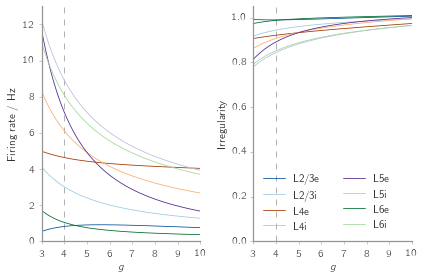

In [14]:
# Plotting
fig = plt.figure()
ax1 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0), rowspan=1, colspan=1)
ax2 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)

for i, population in enumerate(model.populations):
    ax1.plot(gs, rates[:, i], linestyle='-', color=colors[i],
        label=hf.rlbl(population))
    ax2.plot(gs, cv_isis[:, i], linestyle='-',  color=colors[i],
        label=hf.rlbl(population))
    
ax1.set_ylabel("Firing rate / Hz")
ax1.set_ylim(0, 13)
ax1.set_xlabel("$g$")

ax2.set_ylabel("Irregularity")
ax2.set_ylim(0., 1.05)
ax2.set_xlabel(r"$g$")
ax2.legend(loc="best", ncol=2)

for ax in fig.axes:
    style.fixticks(ax)
    # Plot working point
    ax.plot([g_nom]*2, ax.get_ylim(), 
         "--", linewidth=1., color="darkgray", alpha=0.9, zorder=0)

fig_name = "change_parameters_g"
# if save_fig:
#     hf.saving_fig(fig, figure_path, fig_name, verbose=False) 

## Predict changing $\nu_{ext}$

In [15]:
r_nom       = 8     # working point
r_low       = 4   # lower boundary
r_up        = 12   # upper boundary
r_step      = 0.1  # step size

n_low       = int((r_nom - r_low) / r_step) + 1
n_up        = int((r_up - r_nom) / r_step) + 1
n           = n_low + n_up - 1 # r=8 only once
rs_low      = np.linspace(r_nom, r_low, n_low, -1)
rs_up       = np.linspace(r_nom, r_up, n_up)
rs_order    = np.concatenate((rs_low, rs_up), axis=0)
rs          = np.concatenate((rs_low[::-1], rs_up[1:]), axis=0)
rates_r       = np.zeros((n, n_populations))

neuron_model    = "iaf_psc_exp"
connection_rule = "fixed_indegree"
weight_rel_sd   = 0.1
g               = 4
root_method='hybr'
options= {"xtol": 1e-13, "maxfev": 10**3}

for rate_ext in rs_order:
    if rate_ext == r_nom:
        v_guess_0 = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])
    
    model_new   = model_class.model(neuron_model=neuron_model,
                                    connection_rule=connection_rule, 
                                    weight_rel_sd=weight_rel_sd, 
                                    g=g, 
                                    rate_ext=rate_ext)
    
    i = np.where(rate_ext==rs)[0][0]   # get the correct index
    v0          = solve_model(model_new, v_guess_0,
                              root_method=root_method, options=options)

    v_guess_0 = v0      # next intial guess
    rates_r[i] = v0

In [16]:
# CV of ISI
cv_isis_r     = np.zeros(rates_r.shape)
for i, v0 in enumerate(rates_r):
    cv_isis_r[i]  = CV_ISI_mf(v0, model=model_class.model(connection_rule=connection_rule, rate_ext=rs[i]))

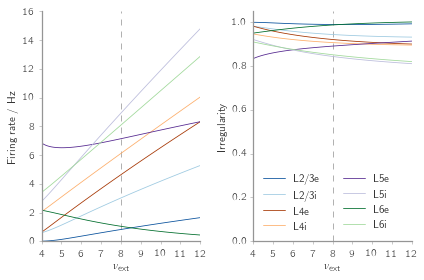

In [17]:
# Plotting
fig = plt.figure()
ax1 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0), rowspan=1, colspan=1)
ax2 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)

for i, population in enumerate(model.populations):
    ax1.plot(rs, rates_r[:, i], linestyle='-', color=colors[i],
        label=hf.rlbl(population))
    ax2.plot(rs, cv_isis_r[:, i], linestyle='-',  color=colors[i],
        label=hf.rlbl(population))
    
ax1.set_ylabel("Firing rate / Hz")
ax1.set_ylim(0,)
ax1.set_xlabel(r"$\nu_\mathrm{ext}$")

ax2.set_ylabel("Irregularity")
ax2.set_ylim(0., 1.05)
ax2.set_xlabel(r"$\nu_\mathrm{ext}$")
ax2.legend(loc="best", ncol=2)

for ax in fig.axes:
    style.fixticks(ax)
    # Plot working point
    ax.plot([r_nom]*2, ax.get_ylim(), 
         "--", linewidth=1., color="darkgray", alpha=0.9, zorder=0)

fig_name = "change_parameters_rate_ext"
# if save_fig:
#     hf.saving_fig(fig, figure_path, fig_name, verbose=False) 